<a href="https://colab.research.google.com/github/MohsenJadidi/Automatic-Modulation-Classification-AMC/blob/master/ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the dataset

In [0]:
import pickle
fileName = 'RML2016.10a_dict.pkl'
with open("/content/drive/My Drive/Colab Notebooks/"+fileName,'rb') as f:
  data = pickle.load(f,encoding='bytes')
  
 

In [3]:
import numpy as np
X = []
labels = [] # label each example by a pair (modulation type, snr)
total_examples = 0
analog = [b'AM-DSB', b'AM-SSB', b'WBFM']

for mod_type, snr in data.keys():
    if (mod_type not in analog):      
        current_matrix = data[(mod_type, snr)]        
        total_examples += current_matrix.shape[0]
        for i in range(current_matrix.shape[0]):
            X.append(current_matrix[i])
            labels.append((str(mod_type, 'ascii'), snr)) # mod_type is of type bytes
    
X = np.array(X)         # First row is QPSK snr=2, seconde is PAM4 snr=8 , ...
labels = np.array(labels)

y = labels[:,0]

print(f'loaded {total_examples} signal vectors into X{X.shape} and their corresponding'
      f' labels into labels{labels.shape}')  
# print(np.unique(labels[:,0]))


loaded 160000 signal vectors into X(160000, 2, 128) and their corresponding labels into labels(160000, 2)


In [4]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_y = LabelEncoder()
y = labelencoder_y.fit_transform(y)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y.reshape(-1,1)).toarray()

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [5]:
snrList = [str(2*i-20) for i in range(20)]  # snrList = -20, -18, -16 , ... ,0, ... ,18
snr = snrList[19]
numberOfEachExamples = 1000
print("SNR :", snr)

SNR : 18


In [0]:
X = X.reshape([X.shape[0],256])
output = [[labels[i*numberOfEachExamples, 0],y[i*numberOfEachExamples]] for i in range(int(X.shape[0]/numberOfEachExamples))]
output = dict(output)

In [0]:
X_snr = []
y_snr = []

for i in range(X.shape[0]):
    if labels[i,1] == snr:
        X_snr.append(X[i])
        y_snr.append(y[i])

X_snr = np.array(X_snr)
y_snr = np.array(y_snr)  

In [0]:
###### Splitting the dataset into the Training set and Test set ######
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 0.2, random_state = 0)
# The below line better for Cross_val part
#X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 1, random_state = 0)


In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Making Simple model

In [18]:
# Importing the Keras libraries and packages
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# Initialising the ANN
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))
dout = 0.2
classifier.add(Dropout(rate = dout))

# Adding the second hidden layer
classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = dout))

classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = dout))

# Adding the output layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

print("Model Created!")

Model Created!


In [19]:
batch = 10
epoch = 25
classifier.fit(X_train, y_train, batch_size = batch, epochs = epoch , validation_data=(X_test, y_test))

Train on 6400 samples, validate on 1600 samples
Epoch 1/25
6400/6400 [==============================] - 4s 555us/step - loss: 1.9084 - acc: 0.2188 - val_loss: 1.7315 - val_acc: 0.3000
Epoch 2/25
6400/6400 [==============================] - 3s 430us/step - loss: 1.6822 - acc: 0.3177 - val_loss: 1.5683 - val_acc: 0.3625
Epoch 3/25
6400/6400 [==============================] - 3s 429us/step - loss: 1.5512 - acc: 0.3622 - val_loss: 1.4887 - val_acc: 0.3844
Epoch 4/25
6400/6400 [==============================] - 3s 439us/step - loss: 1.4838 - acc: 0.3739 - val_loss: 1.4618 - val_acc: 0.4031
Epoch 5/25
6400/6400 [==============================] - 3s 440us/step - loss: 1.4623 - acc: 0.3897 - val_loss: 1.4341 - val_acc: 0.3956
Epoch 6/25
6400/6400 [==============================] - 3s 425us/step - loss: 1.4250 - acc: 0.4028 - val_loss: 1.4235 - val_acc: 0.4069
Epoch 7/25
6400/6400 [==============================] - 3s 422us/step - loss: 1.3940 - acc: 0.4158 - val_loss: 1.3239 - val_acc: 0.4369


# Prediction 

In [20]:
y_pred = classifier.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_real = np.argmax(y_test, axis=1)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_real, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

acc_test = classifier.evaluate(X_test, y_test)[1]
acc_train = classifier.evaluate(X_train, y_train)[1]

print("Acc Test : ", acc_test)
print("Acc Train : ", acc_train)

6400/6400 [==============================] - 0s 34us/step
Acc Test :  0.474375
Acc Train :  0.54078125


#Cross_val(mean accuracy)

In [0]:
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))    
    dout = 0.1
    classifier.add(Dropout(p = dout))
    classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dropout(p = dout))
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
batch = 10
epoch = 25
classifier = KerasClassifier(build_fn = build_classifier, batch_size = batch, epochs = epoch)
# It is better test_size = 1 in Splitting the dataset part
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, n_jobs = 1)
mean = accuracies.mean()
variance = accuracies.std()

# Accuracy vs Droupout

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

means = []
for i in range(16):
  def build_classifier():
      classifier = Sequential()
      classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))
      dout = 0.05*i
      classifier.add(Dropout(rate = dout))
      classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
      classifier.add(Dropout(rate = dout))
      classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))
      classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
      return classifier

  print("Dropout :", 0.05*i)
  batch = 10
  epoch = 25
  classifier = KerasClassifier(build_fn = build_classifier, batch_size = batch, epochs = epoch, verbose=0)
  # It is better test_size = 1 in Splitting the dataset part
  accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 5, n_jobs = 1)
  mean = accuracies.mean()
  variance = accuracies.std()
  print(mean)
  means.append(mean)

Plot Saved!


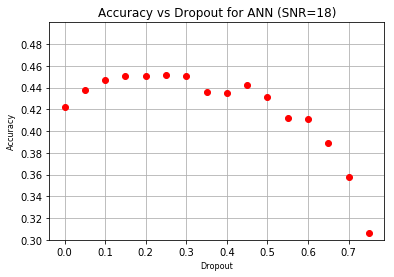

In [0]:

import matplotlib.pyplot as plt

ax = plt.plot(d, means, 'ro')
plt.grid()
plt.title('Accuracy vs Dropout for ANN (SNR=18)')
plt.xlabel('Dropout', fontsize=8)
plt.ylabel('Accuracy', fontsize=8)
plt.ylim([0.30,0.5])
plt.yticks(np.arange(0.3, 0.5, step=0.02))


dic = "/content/drive/My Drive/Colab Notebooks/"
# fig = ax.get_figure()
plt.savefig(dic+f"/Pic/ANN-CrossVal(5)-132-132-ba{batch}-ep{epoch}(SNR={snr}).png", dpi=175, bbox_inches='tight')
plt.savefig(dic+f"/Pic/ANN-CrossVal(5)-132-132-ba{batch}-ep{epoch}(SNR={snr}).eps", bbox_inches='tight')

print("Plot Saved!")

# Iteration in Keras_val model

In [0]:
layer2_snr = []
layer3_snr = []
layer4_snr = []
layer5_snr = []
layer6_snr = []

In [0]:
for d in range(20):
    snr = snrList[d]
    print("layer2 ",snr)
    
    X_snr = []
    y_snr = []
    
    for i in range(X.shape[0]):
        if labels[i,1] == snr:
            X_snr.append(X[i])
            y_snr.append(y[i])
    
    X_snr = np.array(X_snr)
    y_snr = np.array(y_snr)        
    
    ###### Splitting the dataset into the Training set and Test set ######
    from sklearn.model_selection import train_test_split
    #X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 0.2, random_state = 0)
    # The below line better for Cross_val part
    X_train, X_test, y_train, y_test = train_test_split(X_snr, y_snr, test_size = 1, random_state = 0)
    
    
    # Feature Scaling
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    
    # Evaluating the ANN
    from keras.wrappers.scikit_learn import KerasClassifier
    from sklearn.model_selection import cross_val_score
    from keras.models import Sequential
    from keras.layers import Dense
    from keras.layers import Dropout
    
    def build_classifier():
        classifier = Sequential()
        dout = 0.2
        classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))    
        classifier.add(Dropout(rate = dout))
        classifier.add(Dense(units = 132, kernel_initializer = 'uniform', activation = 'relu'))
        classifier.add(Dropout(rate = dout))
        classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))
        classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
        return classifier
    classifier = KerasClassifier(build_fn = build_classifier)
    batch = 10
    epoch = 25
    classifier = KerasClassifier(build_fn = build_classifier, batch_size = batch, epochs = epoch, verbose=0)
    # It is better test_size = 1 in Splitting the dataset part
    accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 4, n_jobs = 1)
    mean = accuracies.mean()
    #variance = accuracies.std()
   
    layer2_snr.append(mean)
    print(mean)
    
print(layer2_snr)    

In [0]:
layer2=[0.12489076040034322, 0.12739257384528158, 0.1345170738121328, 0.15014420025704756, 0.20752582978023465, 0.2649089599224278, 0.3564198413424906, 0.4423055342168805, 0.5139379752755842, 0.5146907897803163, 0.41467534404171125, 0.4306783463397232, 0.444177845674313, 0.44318222300639154, 0.43767822050047345, 0.4430519698061917, 0.43430715974300105, 0.42892997136097744, 0.4316777831801456, 0.4411802220803449]
layer3=[0.12839132328977573, 0.1280133217647569, 0.129141010790849, 0.14714313703179155, 0.19064914112870096, 0.2759097734660147, 0.3482970303279758, 0.4309272202443361, 0.5156864129550142, 0.49231247592676874, 0.416302157891672, 0.43942865825097, 0.45430328348446997, 0.46105853630153426, 0.44367909604618294, 0.44330272001746845, 0.45493140986521896, 0.4470553479792635, 0.44692984663369345, 0.45380678479010894]
layer4=[0.12351788633116793, 0.12013913454551747, 0.1282668859016741, 0.13376694868162195, 0.19127345332202633, 0.25528314706813515, 0.3454194663197879, 0.4405527833125705, 0.5199401008726665, 0.46806009894912004, 0.43530203233933307, 0.4391819723857322, 0.4573043470170997, 0.4614324730419912, 0.4390564107892242, 0.4456797834952968, 0.4420585991299547, 0.4436797836889327, 0.44880403388569734, 0.45930953624193793]
layer6=[0.12176488498030133, 0.1206392595865971, 0.1263911355274071, 0.13051619836136702, 0.18102239030261916, 0.2550320215183932, 0.3325442786952327, 0.4048007819840751, 0.4590520329241515, 0.4101771581712262, 0.4276769702980111, 0.4348042838300544, 0.4451785335386672, 0.44567940908071846, 0.4253042841522818, 0.43630090747900746, 0.4334299094650546, 0.42992897172329886, 0.4370537209871219, 0.43930741033364473]
layer5=[0.1215151350374048, 0.12564076038452518, 0.12901626068493513, 0.13426782412679977, 0.19539807813905047, 0.2656578972355545, 0.3444180280829418, 0.43130284556253384, 0.5000635384031715, 0.4233030332383206, 0.42655278284296494, 0.44280603514509964, 0.44980347093662476, 0.45055428394180286, 0.4396790965828064, 0.4369294086336464, 0.43793309848314865, 0.44367940879573653, 0.442431347613242, 0.4561860372124099]

# Grid Search

In [0]:
# Tuning the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout

def build_classifier(n1):
    classifier = Sequential()
    classifier.add(Dense(units = n1, kernel_initializer = 'uniform', activation = 'relu', input_dim = 256))    
    dout = 0.2
    classifier.add(Dropout(p = dout))
    classifier.add(Dense(units = n1, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dropout(p = dout))
    classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [10, 25, 50, 75, 100],
              'epochs': [10, 20, 50, 100],
              'optimizer': ['adam', 'rmsprop'],
              'n1':[66, 99, 165, 198, 231, 264, 297 ,396],
              'n2':[66, 99, 165, 198, 231, 264, 297 ,396]}

parameters = {'n1':[66, 99, 165, 198, 231, 264, 297 ,396]}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 2)

grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

print('best_parameters : ', best_parameters)
print('best_accuracy : ', best_accuracy)

# Plot Confusion Matrix

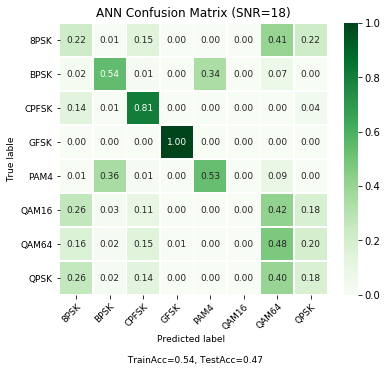

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
modulation_order = []
modulation_order_dict = dict()

for key,value in output.items():
    modulation_order_dict[np.argmax(value)] = str(key)
    
for i in range(8):
    modulation_order.append(modulation_order_dict[i])
    
    
    
cmDataFrame = pd.DataFrame(cm_norm, index=modulation_order, columns = modulation_order)
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cmDataFrame, annot=True, annot_kws={"size": 9}, fmt='.2f', linewidths=.5, cmap="Greens")

plt.title(f"ANN Confusion Matrix (SNR={snr})")
plt.xlabel("Predicted label  \n\n TrainAcc={:.2}, TestAcc={:.2}".format(acc_train,acc_test), fontsize=9)
plt.ylabel("True lable", fontsize=9)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor", fontsize=9)
plt.setp(ax.get_yticklabels(), fontsize=9)
fig = ax.get_figure()

In [17]:
dic = "/content/drive/My Drive/Colab Notebooks/"
fig.savefig(dic+f"/Pic/ANN-132-132-132-132-ba{batch}-ep{epoch}(SNR={snr}).png", dpi=175, bbox_inches='tight')
fig.savefig(dic+f"/Pic/ANN-132-132-132-132-ba{batch}-ep{epoch}(SNR={snr}).eps", bbox_inches='tight')
print("Plot Saved!")

Plot Saved!
